# COMP-767 : Reinforcement Learning - Assigment 1

## Bandits algorithm
Best-arm identification: also sometimes called pure exploration, this is a problem formulation
in which the learner is allowed a period of experimentation of a fixed length, after which it
has to act forever according to the policy it identifies as being best. No further learning is
allowed after the ”pure exploration” phase.
For this part of the assignment you will have to read the following paper:
Best-arm identification algorithms for multi-armed bandits in the fixed confidence setting,
Kevin Jamieson and Robert Nowak, CISS, 2014
https://people.eecs.berkeley.edu/˜kjamieson/resources/bestArmSurvey.pdf
The paper describes two different classes of algorithms for this problem. Your task is to: (a)
summarize the main results in the paper; (b) Reproduce the results in Figure 1 (c) Perform
the same empirical comparison on the bandit problem provided in the Sutton & Barto book
(which we discussed in class). Do not forget to average your results over multiple independent runs. (d) discuss in a short paragraph a concrete application in which you think regret
optimization would be more useful than best arm identification.


(a) Summarize the main results in the paper

The paper present two algorithms, exponential-gap elimination and a UCB style algorithm, that have the same optimal query complexity of $\sum\limits_{i \ne i^{*}} \Delta_i^{-2} \log \log \Delta_i^{-2}$. These algorithms are based on three general sampling strategies : Action elimination, UCB and LUCB that is only a variation on UCB.
Action elimination samples multiple arms at each round, it samples each arm which estimated mean augmented by an uncertainty upper bound is higher than  a reference arm. It is formulated like this $$\Omega_{k+1} = \{i \in \Omega_{k} : \hat{\mu}_{a, T_a(t)} - C_{a, T_a(t)} < \hat{\mu}_{a, T_a(t)} - C_{i, T_i(t)}\}$$

UCB samples the arm with highest mean augmented by an uncertainty , it is formulated like this : $$arg \max_{i \in [n]} \hat{\mu}_{i, T_i(t)} + C_{i, T_i(t)}$$

LUCB defines the arms $h_t$, the best arm so far,  and $l_t$, the second best arm so far,  at each round and samples them both. $$h_t = arg \max_{i \in [n]} \hat{\mu}_{i, T_i(t)}$$ $$l_t = arg \max_{i \in [n]} \hat{\mu}_{i, T_i(t)}$$
The paper then shows concise new proofs of the optimality of these algorithms. The proof of the sample complexity of the LUCB algorithm is the best to date. Then an empirical comparison of done on a given test bed that shows that UCB and LUCB make a choice of good arms much faster action elimination.  

(b) Reproduce the results in Figure 1

In [11]:
%load_ext autoreload
%autoreload 2

import bandits

#for problem 2
import numpy as np
import gym
import gym_gridworld
import dynamic_programming

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


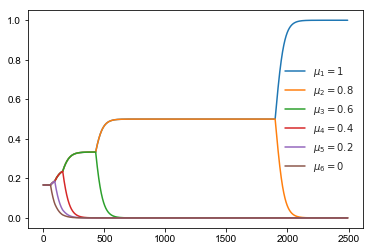

In [26]:
bandits.trial_bandit(bandits.ActionEliminationBanditTrial, n_trials=1, n_time_steps=2500)

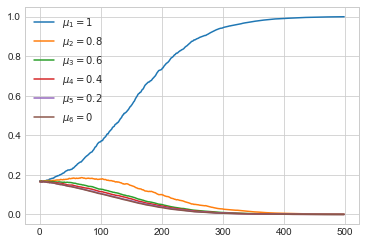

In [27]:
bandits.trial_bandit(bandits.UCBBanditTrial, n_trials=5, n_time_steps=500)

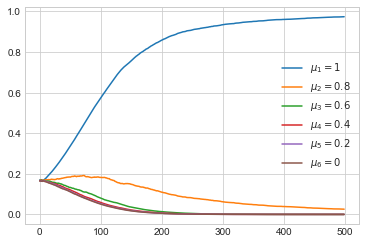

In [28]:
bandits.trial_bandit(bandits.LUCBBanditTrial, n_trials=5, n_time_steps=500)

(c) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). Do not forget to average your results over multiple independent runs.

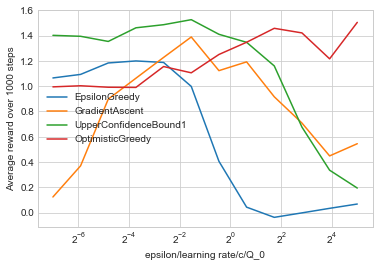

In [29]:
bandits.plot_parameter_study(nb_test = 100, nb_step = 500, k=10, start=-7, end=5, precision=1)

(d) Discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identification

Regret is the opportynity loss for one step  and is defined as $I_t = \mathbb{E}[ V^{*} - Q(a_t)] = \mathbb{E}[\Delta_a]$, where $Q(a_t)=\mathbb{E}[r|a]$ is the action-value that represent the expected reward for action $a$ and $V^{*} = Q(a{*}) = \max_{a\in \mathcal{A}} Q(a)$ is the optimal value for the optimal action $a^{*}$. The toal regret is the total opportunity loss and is defined as $L_t =\mathbb{E}[ \sum\limits_{\tau=1}^{t} V^{*} - Q(a_t)] = \sum\limits_{a\in \mathcal{A}} \mathbb[N_t(a)] \Delta_a$. With these definitions, total regret minimization would be more useful than best arm identification in the case where the true value of the different $\Delta$ are known but not the assosiated arms. In this situation, the number of pulls would be minimized for the high $\Delta$

# Markov Decision Processes and dynamic programming

Implement and compare empirically the performance of value iteration, policy iteration and
modified policy iteration. Modified policy iteration is a simple variant of policy iteration in
which the evaluation step is only partial (that is, you will make a finite number of backups
to the value function before an improvement step). You can consult the Puterman (1994)
1
textbook for more information. You should implement your code in matrix form. Provide
your code as well as a summary of the results, which shows, as a function of the number
of updates performed, the true value of the greedy policy computed by your algorithm, from
the bottom left state and the bottom right state. That is, you should take the greedy policy
currently considered by your algorithm and compute its exact value.
To test your algorithm, use a grid world in which, at each time step, your actions move in the
desired direction w.p. p and in a random direction w.p. (1 − p). The grid is empty, of size
n × n. There is a positive reward of +10 in the upper right corner and a positive reward of
+1 in the upper left corner. All other rewards are 0. The positive-reward states are absorbing
(i.e. terminal). If the agent bumps into the edge of the grid as a result of a transition, it stays
in the same spot. The discount factor is γ = 0.9.
You need to test your algorithm with two different values of p (0.9 and 0.7) and with two
different sizes of grid (n = 5 and n = 50). Explain what you see in these results.


To represent the policy I used arrows to indicate the direction of the agent, and black squares to represent the terminal states. To compute the true value of the policy I used 100 independent walks and averaged the discounted return to get an estimate, because of the possibility of a random action at each step.

In [6]:
def print_policy(policy, terminal_states):
    arrows = {0: '\u2191', 1:'\u2192' , 2:'\u2193' , 3:'\u2190'}
    terminal_state = '\u25A0'
    n = int(np.sqrt(len(policy)))
    for i in range(n):
        string = ""
        for j in range(n):
            ij = i*n + j
            if ij in terminal_states:
                string += terminal_state
            else:
                string += arrows[policy[ij]]
        print(string)

def print_V_PI(V, PI, terminal_states):
    n = np.sqrt(len(V)).astype(int)
    print("\nV\n", np.array(V).round(1).reshape(n,n))
    print("\nPI")
    print_policy(PI, terminal_states)

In [21]:
def compute_policy_iteration(env, dicount_factor, modified_max_k=np.Inf):
    V, PI, k = dynamic_programming.policy_iteration(env, dicount_factor, modified_max_k = modified_max_k)
    print("POLICY ITERATION" if  modified_max_k==np.Inf else "MODIFIED POLICY ITERATION")
    print(f"Policy found in {len(k)} iterations, where each policy evaluation lasted for k = {k}, which totals {np.sum(k)} sweeps")
    print_V_PI(V, PI, env.terminal_states)
    
def compute_value_iteration(env, dicount_factor):
    V, PI, k = dynamic_programming.value_iteration(env, dicount_factor)
    print("VALUE ITERATION")
    print(f"Policy found in {k} iterations")
    print_V_PI(V, PI, env.terminal_states)
    
def hyper_parameter_testing(n=10, p_action_works=0.9, dicount_factor = 0.9, modified_max_k=np.Inf, epsilon=1e-5):
    env = gym.make("gridworld-v0", n=n, p_action_works=p_action_works)

    compute_policy_iteration(env, dicount_factor)
    compute_policy_iteration(env, dicount_factor, modified_max_k)
    compute_value_iteration(env, dicount_factor)

In [22]:
hyper_parameter_testing(n=5, p_action_works=0.7, dicount_factor = 0.7, modified_max_k=3)

POLICY ITERATION
Policy found in 5 iterations, where each policy evaluation lasted for k = [21, 12, 11, 8, 4], which totals 56 sweeps

V
 [[0.  3.3 5.4 8.8 0. ]
 [1.4 2.3 3.6 5.6 8.8]
 [0.9 1.4 2.3 3.6 5.4]
 [0.6 0.9 1.4 2.3 3.3]
 [0.4 0.6 1.  1.5 2.1]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑
MODIFIED POLICY ITERATION
Policy found in 5 iterations, where each policy evaluation lasted for k = [3, 3, 3, 3, 3], which totals 15 sweeps

V
 [[0.  3.3 5.4 8.8 0. ]
 [1.4 2.3 3.6 5.6 8.8]
 [0.9 1.4 2.3 3.6 5.4]
 [0.6 0.9 1.4 2.3 3.3]
 [0.4 0.6 1.  1.5 2.1]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑
VALUE ITERATION
Policy found in 12 iterations

V
 [[0.  3.3 5.4 8.8 0. ]
 [1.4 2.3 3.6 5.6 8.8]
 [0.9 1.4 2.3 3.6 5.4]
 [0.6 0.9 1.4 2.3 3.3]
 [0.4 0.6 1.  1.5 2.1]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


In [23]:
hyper_parameter_testing(n=5, p_action_works=0.9, dicount_factor = 0.7, modified_max_k=3)

POLICY ITERATION
Policy found in 5 iterations, where each policy evaluation lasted for k = [19, 8, 6, 5, 3], which totals 41 sweeps

V
 [[0.  4.4 6.5 9.6 0. ]
 [2.1 3.  4.5 6.6 9.6]
 [1.4 2.1 3.  4.5 6.5]
 [1.  1.4 2.1 3.  4.4]
 [0.7 1.  1.4 2.1 3. ]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑
MODIFIED POLICY ITERATION
Policy found in 6 iterations, where each policy evaluation lasted for k = [3, 3, 3, 3, 3, 3], which totals 18 sweeps

V
 [[0.  4.4 6.5 9.6 0. ]
 [2.1 3.  4.5 6.6 9.6]
 [1.4 2.1 3.  4.5 6.5]
 [1.  1.4 2.1 3.  4.4]
 [0.7 1.  1.4 2.1 3. ]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑
VALUE ITERATION
Policy found in 9 iterations

V
 [[0.  4.4 6.5 9.6 0. ]
 [2.1 3.  4.5 6.6 9.6]
 [1.4 2.1 3.  4.5 6.5]
 [1.  1.4 2.1 3.  4.4]
 [0.7 1.  1.4 2.1 3. ]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


In [24]:
hyper_parameter_testing(n=50, p_action_works=0.7, dicount_factor = 0.9, modified_max_k=3)

POLICY ITERATION
Policy found in 41 iterations, where each policy evaluation lasted for k = [41, 52, 36, 25, 8, 7, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], which totals 215 sweeps

V
 [[0.  0.9 0.8 ... 8.1 9.5 0. ]
 [0.9 0.8 0.7 ... 7.1 8.2 9.5]
 [0.8 0.7 0.6 ... 6.2 7.1 8.1]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

PI
■←←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→■
↑←←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑↑←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑
↑↑↑↑←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑
↑↑↑↑↑←←←←←←←←←←←↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑
↑↑↑↑↑↑←←←←←←←←←←↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑
↑↑↑↑↑↑↑←←←←←←←←↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑←←←←←←↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑←←←←↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑←↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑

In [25]:
hyper_parameter_testing(n=50, p_action_works=0.9, dicount_factor = 0.9, modified_max_k=3)

POLICY ITERATION
Policy found in 32 iterations, where each policy evaluation lasted for k = [74, 40, 31, 27, 16, 12, 6, 6, 5, 5, 5, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], which totals 253 sweeps

V
 [[0.  1.  0.9 ... 8.8 9.9 0. ]
 [1.  0.9 0.8 ... 7.8 8.8 9.9]
 [0.9 0.8 0.7 ... 7.  7.8 8.8]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

PI
■←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→■
↑↑←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑↑←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑
↑↑↑↑←←←←←←←←←←↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑
↑↑↑↑↑←←←←←←←←↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑
↑↑↑↑↑↑←←←←←←↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑
↑↑↑↑↑↑↑←←←←↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑←←↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

## Explanation
In these result, we can see that that the three algorithms converge to the same optimal policy. Modified policy iteration gets the same result as policy iteration, but the number of iteration is much greater. The greater the discout factor is the greater is the influence of the reward in the state in the top left. We can see that a larger number of cell in grid world will go in the direction of the biggest reward when the discount factor is high. Also the bigger grid world is the smaller the reward on the lower edge are, the is simply because it take a higher number of step of get to a terminal state.